In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import os

In [2]:
sc._settings.ScanpyConfig.n_jobs = -1

In [3]:
def z_score_normalization(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

def reorder_columns(df, col_changed, col_position) -> pd.DataFrame:
    """
    Reordering colums. The second input can either be an integer for index or it can be a reference column name. If reference column name is chosen, the column will be placed after the reference column.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("The first argument must be a pandas DataFrame")
    if not isinstance(col_changed, str):
        raise ValueError("The second argument must be a string representing a column name")
    if not isinstance(col_position, (str, int)):
        raise ValueError("The third argument must be either a string representing a column name or an integer representing a column index")
    if isinstance(col_position, int):
        cols = df.columns.tolist()
        if col_changed in cols and col_position <= len(cols) + 1:
            cols.remove(col_changed)
        
            index = col_position
            cols.insert(index, col_changed)
            
            df = df[cols]
    else:
        cols = df.columns.tolist()
        if col_changed in cols and col_position in cols:
            cols.remove(col_changed)
            index = cols.index(col_position)
            cols.insert(index+1, col_changed)
            
            df = df[cols]
    return df

In [ ]:
df_list=[]
for csv in os.listdir('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets/cHL_2_MIBI/quantification/'):
    if csv.endswith('.csv') and not csv.startswith('.'):
        df = pd.read_csv(os.path.join('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets/cHL_2_MIBI/quantification/', csv))
        df['csv'] = [csv for _ in range(len(df))]
        columns = df.columns.tolist()
        new_order = columns[6:] + columns[:6]
        df = df[new_order]
        df = reorder_columns(df, 'Annotation', 'Annotation_num')
        df_list.append(df)
df = pd.concat(df_list)


In [ ]:
df.columns

In [ ]:
# Preprocessing for STELLAR without coordinate drop
df.drop(columns=['Annotation_num'], inplace=True)
df.rename(columns={'Annotation': 'cell_type', 'X_cent': 'x', 'Y_cent': 'y'}, inplace=True)
df = reorder_columns(df, 'y', 'cellSize')
df = reorder_columns(df, 'x', 'cellSize')
df = reorder_columns(df, 'csv', 'y')

In [ ]:
df.to_csv('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets/Maps_data/cHL_2_MIBI/quantification/processed/cHL2_MIBI_cleaned.csv', index=False)

In [ ]:
X_columns = df.columns[:df.columns.get_loc('csv')]
obs_columns = df.columns[df.columns.get_loc('csv'):]
adata = ad.AnnData(
    X=df[X_columns],
    obs=df[obs_columns],
    var=pd.DataFrame(index=X_columns)
)

In [5]:
X_columns = df.columns[:df.columns.get_loc('cell_id')]
obs_columns = df.columns[df.columns.get_loc('cell_id'):]
adata = ad.AnnData(
    X=df[X_columns],
    obs=df[obs_columns],
    var=pd.DataFrame(index=X_columns)
)

/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
adata.raw = adata
adata.X = np.arcsinh(adata.X)
adata.layers['zscore'] = z_score_normalization(adata.X)

In [ ]:
adata.var_names

In [8]:
remove = ['Histone H3', 'dsDNA', 'Na-K ATPase']
adata = adata[:, ~adata.var_names.isin(remove)]

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color='cell_type')

In [10]:
adata.X = np.arcsinh(adata.X)

/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_68835/2232165670.py:1: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata.X = np.arcsinh(adata.X)


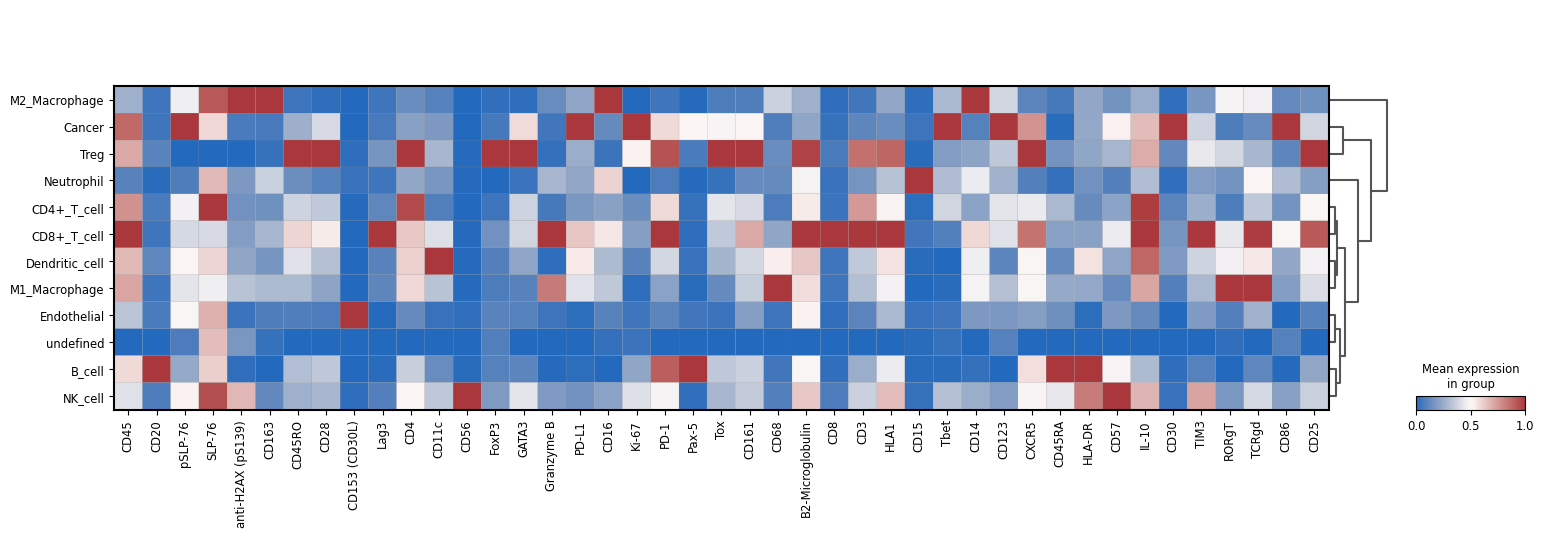

In [14]:
sc.pl.matrixplot(adata, var_names=adata.var_names, groupby='cell_type', cmap='vlag', use_raw=False, dendrogram=True, standard_scale='var')

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='cell_type' , method='wilcoxon')

In [ ]:
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.2, max_out_group_fraction = 0.8, key = 'rank_genes_groups', key_added='rank_genes_groups_filtered')

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, standard_scale='var', key='rank_genes_groups')

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, standard_scale='var', key='rank_genes_groups_filtered')

## Harmonization of celltype labels

In [ ]:
df = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/cHL_2_MIBI_quantification.csv')

In [ ]:
df

In [ ]:
df['cell_type'].value_counts()

In [ ]:
df['cell_type'] = df['cell_type'].replace({'CD4 T':'CD4+_T_cell', 'CD4 Treg':'Treg', 'B':'B_cell', 'M2':'M2_Macrophage', 'DC':'Dendritic_cell', 'CD8 T':'CD8+_T_cell',
                                           'Tumor':'Cancer', 'M1':'M1_Macrophage', 'NK':'NK_cell', 'Other':'unedfined'})

In [ ]:
df.to_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/cHL_2_MIBI_quantification.csv', index=False)

# Implement different levels of granularity

In [ ]:
df = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/cHL_2_MIBI_quantification.csv')
df['cell_type'].value_counts()

In [ ]:
df['level_2_cell_type'] = df['cell_type']
df['level_2_cell_type'] = df['level_2_cell_type'].replace({'CD4+_T_cell':'Lymphoid_immune', 'CD8+_T_cell': 'Lymphoid_immune', 'M2_Macrophage':'Myeloid_immune', 'B_cell':'Lymphoid_immune',
                                                           'Dendritic_cell':'Myeloid_immune', 'Treg':'Lymphoid_immune', 'NK_cell':'Lymphoid_immune',
                                                           'Endothelial':'Vascular', 'Neutrophil':'Myeloid_immune', 'M1_Macrophage':'Myeloid_immune',})
df['level_2_cell_type'].value_counts()

In [ ]:
df['level_1_cell_type'] = df['level_2_cell_type']
df['level_1_cell_type'] = df['level_1_cell_type'].replace({'Lymphoid_immune':'Immune', 'Myeloid_immune':'Immune', 'Vascular':'Stromal'})
df['level_1_cell_type'].value_counts()

In [ ]:
df = reorder_columns(df, 'cell_type', 'level_1_cell_type')
df = reorder_columns(df, 'level_2_cell_type', 'level_1_cell_type')
df 

In [ ]:
df.to_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/cHL_2_MIBI_quantification.csv', index=False)

# Encode uninfomrative variables 

In [2]:
df = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/cHL_2_MIBI_quantification.csv')
df.columns

Index(['CD45', 'CD20', 'dsDNA', 'pSLP-76', 'SLP-76', 'anti-H2AX (pS139)',
       'CD163', 'Histone H3', 'CD45RO', 'CD28', 'CD153 (CD30L)', 'Lag3', 'CD4',
       'CD11c', 'CD56', 'FoxP3', 'GATA3', 'Granzyme B', 'PD-L1', 'CD16',
       'Ki-67', 'PD-1', 'Pax-5', 'Tox', 'CD161', 'CD68', 'B2-Microglobulin',
       'CD8', 'CD3', 'HLA1', 'CD15', 'Tbet', 'CD14', 'CD123', 'CXCR5',
       'CD45RA', 'HLA-DR', 'CD57', 'IL-10', 'CD30', 'TIM3', 'RORgT', 'TCRgd',
       'CD86', 'CD25', 'Na-K ATPase', 'cell_id', 'cellSize', 'x', 'y',
       'sample_id', 'level_1_cell_type', 'level_2_cell_type', 'cell_type'],
      dtype='object')

In [3]:
df['cell_type'].nunique()

12

In [3]:
df = df.rename(columns={'cellLabel': 'cell_id', 'csv': 'sample_id'})

In [5]:
df.dtypes

CD45                 float64
CD20                 float64
dsDNA                float64
pSLP-76              float64
SLP-76               float64
anti-H2AX (pS139)    float64
CD163                float64
Histone H3           float64
CD45RO               float64
CD28                 float64
CD153 (CD30L)        float64
Lag3                 float64
CD4                  float64
CD11c                float64
CD56                 float64
FoxP3                float64
GATA3                float64
Granzyme B           float64
PD-L1                float64
CD16                 float64
Ki-67                float64
PD-1                 float64
Pax-5                float64
Tox                  float64
CD161                float64
CD68                 float64
B2-Microglobulin     float64
CD8                  float64
CD3                  float64
HLA1                 float64
CD15                 float64
Tbet                 float64
CD14                 float64
CD123                float64
CXCR5         

In [6]:
df.to_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/cHL_2_MIBI_quantification.csv', index=False)

In [4]:
df = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/cHL_2_MIBI_quantification.csv')


In [3]:
df['cell_type'].value_counts()

cell_type
CD4+_T_cell       54832
Treg              39962
B_cell            24129
M2_Macrophage     23726
Dendritic_cell    19824
Neutrophil        16833
unedfined         15758
CD8+_T_cell       13120
Cancer             7102
Endothelial        5809
M1_Macrophage      4909
NK_cell            4885
Name: count, dtype: int64

In [4]:
df['level_2_cell_type'] = df['level_2_cell_type'].replace({'unedfined':'undefined'})
df['level_1_cell_type'] = df['level_1_cell_type'].replace({'undefined':'Undefined'})
df['cell_type'] = df['cell_type'].replace({'unedfined':'undefined'})
df['cell_type'].value_counts()

cell_type
CD4+_T_cell       54832
Treg              39962
B_cell            24129
M2_Macrophage     23726
Dendritic_cell    19824
Neutrophil        16833
undefined         15758
CD8+_T_cell       13120
Cancer             7102
Endothelial        5809
M1_Macrophage      4909
NK_cell            4885
Name: count, dtype: int64

In [5]:
df.to_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/cHL_2_MIBI_quantification.csv', index=False)